In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import io
import base64
import random

import gym
from gym import wrappers
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from lib import get_network
from lib.agent import DQN
from lib.logging import Logger
from lib.rollout import ReplayBuffer
from lib.utils import get_html_video_string, train, plot_progress

from IPython.display import HTML

plt.style.use('seaborn-v0_8')

### In this assignment you are going to:
* implement DQN and doubleDQN
* use them on CartPole, LunarLander and (Optionally) BreakOut environments

### We use PyTorch for neural networks. If you are new to PyTorch see tutorials:
https://pytorch.org/tutorials/ <br>
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [3]:
SEED = 0xCEEEEEEB
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
log_root = Path("results")
log_root.mkdir(exist_ok=True)

# ATARI [Optional]

In this section, you can try the algorithm on the larger problem from Atari suit. This section is optional. The training procedure is computationally cumbersome, so that ideally one may want to use GPU and powerful CPU for this task. Also note, that usually people choose larger `buffer_size` for this benchmark, which may consume anormous amount of RAM. To avoid the memory overflow, you may consider to use lossless compression algorithm to save a lot of space by compressing observations. See RLLib or Catalyst.RL for example.

If you decided to go through the task, note, that typical choice of hyperparameters for Atari differs from previous ones. See RLLib's configs, for example, as a reference.

In [5]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
from lib.utils import TransposeImage

In [6]:
def make_env(name, seed=None, monitor=False):
    env = gym.make(name)

    is_atari = hasattr(gym.envs, 'atari') and isinstance(
        env.unwrapped, gym.envs.atari.atari_env.AtariEnv)

    if is_atari:
        max_epi_steps = 108000
        if max_epi_steps < 0:
            max_epi_steps = None

        env = make_atari(name, max_epi_steps)
        env = wrap_deepmind(env, True, True, True, True)
        env = TransposeImage(env, op=[2, 0, 1])
        
    if monitor:
        env = wrappers.Monitor(env, "./gym-results", force=True)
    if seed:
        env.seed(seed)


    return env

In [7]:
env = make_env("BreakoutNoFrameskip-v4", monitor=True)
obs = env.reset()
while True:
    act = env.action_space.sample()
    if env.step(act)[2]: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

In [8]:
env = make_env("BreakoutNoFrameskip-v4", SEED)

value_network = get_network("vision")(
    env.observation_space.shape[0],
    256,
    env.action_space.n)

agent = DQN(
    value_network,
    env.action_space,
    eps=0.2,
    eps_decay=(.2 - .02) / 10**5,
    batch_size=32,
    learning_rate=5e-4,
    discount_factor=0.99,
    double=True
)

In [9]:
agent = train(
    agent,
    env,
    log_dir=log_root / "lunarlander-v2",
    prefix="_double_dqn",
    buffer_size=5 * 10**4,
    n_steps=10**4,
    warmup_steps=500,
    target_update_every=100,
    log_every=500,
    save_every=500
)

/home/vsydorskyi/src/rl-assignments/lib/agent.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  v_s0 = FloatTensor(v_s0)


----------------------------------
| reward/reward_mean | 0.1875    |
| reward/reward_max  | 2         |
| reward/reward_min  | 0         |
| reward/reward_std  | 0.46351   |
| loss/bellman_error | 0.0095134 |
| misc/q             | 0.025121  |
| misc/q_est         | 0.022023  |
| misc/epsilon       | 0.1982    |
| misc/timestep      | 1000      |
----------------------------------
----------------------------------
| reward/reward_mean | 0.66667   |
| reward/reward_max  | 2         |
| reward/reward_min  | 0         |
| reward/reward_std  | 0.66667   |
| loss/bellman_error | 0.0029046 |
| misc/q             | 0.059654  |
| misc/q_est         | 0.058131  |
| misc/epsilon       | 0.1973    |
| misc/timestep      | 1500      |
----------------------------------
----------------------------------
| reward/reward_mean | 0.26667   |
| reward/reward_max  | 1         |
| reward/reward_min  | 0         |
| reward/reward_std  | 0.44222   |
| loss/bellman_error | 0.0032076 |
| misc/q            

In [10]:
env = make_env("BreakoutNoFrameskip-v4", monitor=True)
obs = env.reset()
while True:
    obs = torch.FloatTensor(obs).unsqueeze(0)
    act = agent.pick_action(obs, force_greedy=True)
    obs, rew, done, info = env.step(act)
    if done: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

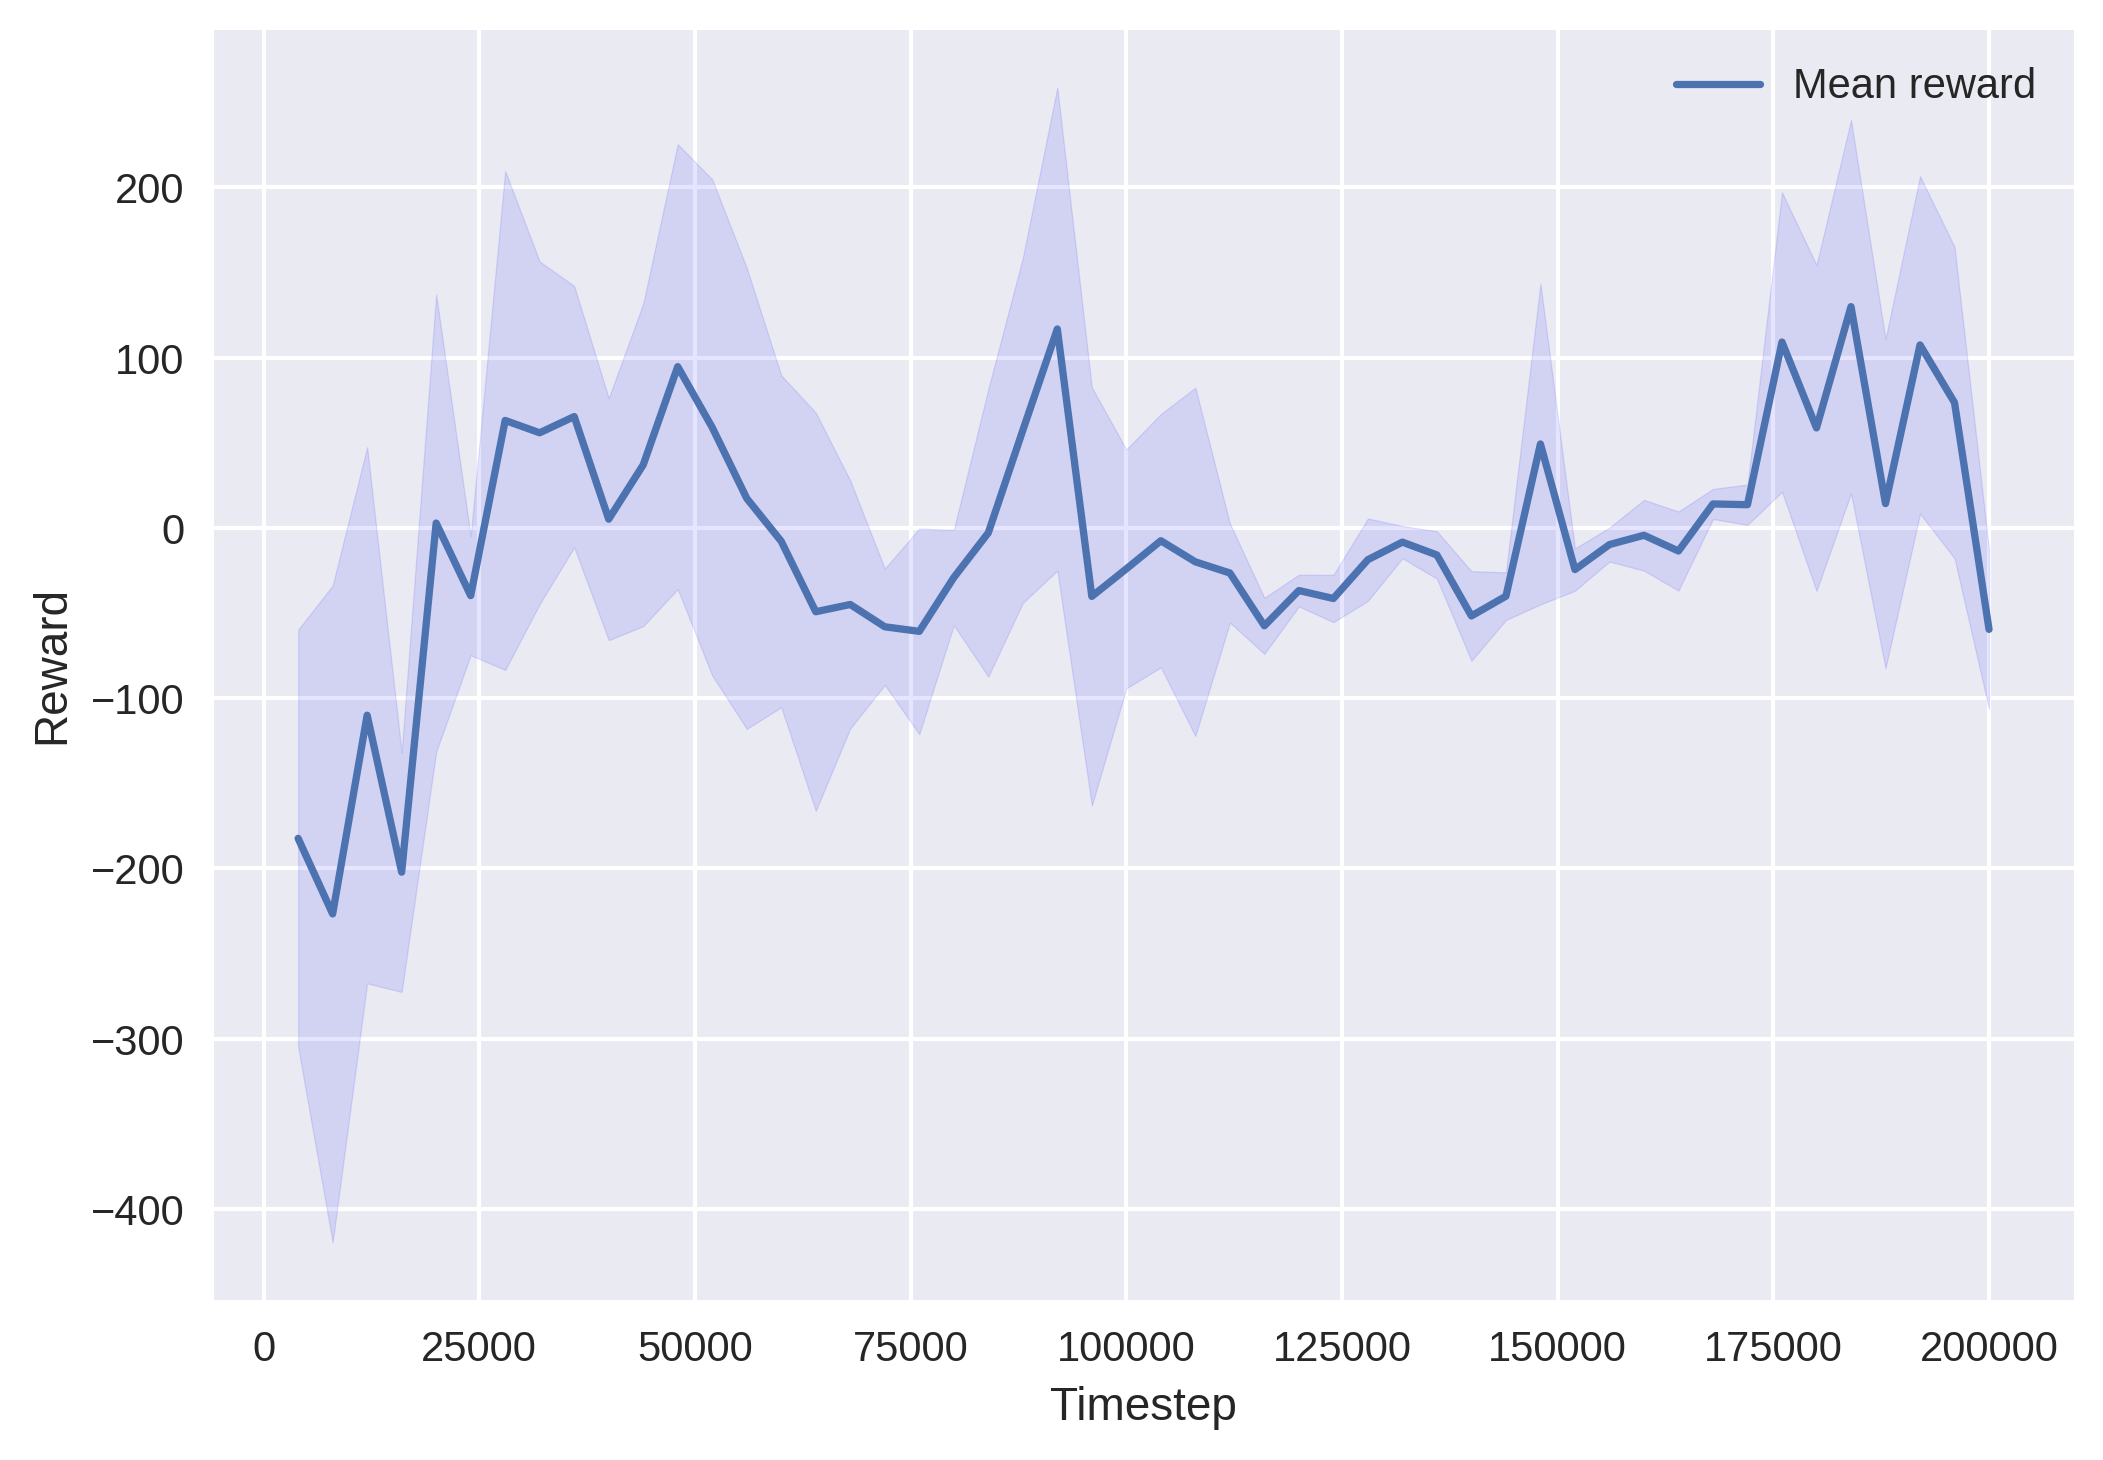

In [12]:
plt.figure(dpi=300)
df = pd.read_csv(str(log_root / "lunarlander-v2" / "logs_dqn.csv"), sep=";")
plot_progress(df)